In [130]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import TweetTokenizer
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from keras.optimizers import SGD
import tensorflow as tf

In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
train_df=pd.read_csv('C:\\Users\\kkesh\\Downloads\\kaggle_comp\\disaster_tweet\\train.csv')

In [72]:
test_df=pd.read_csv('C:\\Users\\kkesh\\Downloads\\kaggle_comp\\disaster_tweet\\test.csv')

In [73]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [74]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [75]:
###Drop Nan Values
train_df=train_df.dropna()

In [76]:
## Get the Independent Features

X=train_df.drop('target',axis=1)

In [77]:
y=train_df['target']

In [78]:
X.shape

(5080, 4)

In [79]:
y.shape

(5080,)

In [80]:
tf.__version__

'2.10.0'

In [81]:
### Vocabulary size
voc_size=10000

In [82]:
messages = X.copy()

In [83]:
train_df['tweet_text'] = train_df.text.str.lower()

In [84]:
train_df['tweet_text'][31]

'@bbcmtd wholesale markets ablaze http://t.co/lhyxeohy6c'

In [85]:
train_df.reset_index(inplace=True)

In [86]:
train_df['tweet_text'][0]

'@bbcmtd wholesale markets ablaze http://t.co/lhyxeohy6c'

In [87]:
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
train_df.tweet_text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

0                       @bbcmtd wholesale markets ablaze 
1           we always try to bring the heavy. #metal #rt 
2       #africanbaze: breaking news:nigeria flag set a...
3                      crying out for more! set me ablaze
4       on plus side look at the sky last night it was...
                              ...                        
5075                        on the bright side i wrecked 
5076    @widda16 ... he's gone. you can relax. i thoug...
5077    three days off from work and they've pretty mu...
5078    #fx #forex #trading cramer: iger's 3 words tha...
5079    @engineshed great atmosphere at the british li...
Name: tweet_text, Length: 5080, dtype: object

In [88]:
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r'@mention', '', x))
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r'#\S+', '', x))
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r':', '', x))
train_df.tweet_text = train_df.tweet_text.apply(lambda x: re.sub(r'-', '', x))
stop_words = stopwords.words('english')
train_df.tweet_text = train_df.tweet_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
tknzr = TweetTokenizer()
train_df['tokens'] = train_df['tweet_text'].apply(tknzr.tokenize)

In [89]:
train_df.head()

,index,id,keyword,location,text,target,tweet_text,tokens
0,31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale markets ablaze,"[bbcmtd, wholesale, markets, ablaze]"
1,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy,"[always, try, bring, heavy]"
2,33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,breaking newsnigeria flag set ablaze aba,"[breaking, newsnigeria, flag, set, ablaze, aba]"
3,34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,crying set ablaze,"[crying, set, ablaze]"
4,35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze,"[plus, side, look, sky, last, night, ablaze]"


In [90]:
PUNCUATION_LIST = list(string.punctuation)
def remove_punctuation(word_list):
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in PUNCUATION_LIST]
train_df['tokens'] = train_df['tokens'].apply(remove_punctuation)

In [91]:
wnl = WordNetLemmatizer()

In [92]:
train_df['tweet_text'] = train_df['tweet_text'].apply(lambda x: " ".join(wnl.lemmatize(word, "v") for word in x.split()))

In [93]:
word_frequency = train_df['tweet_text'].str.split(expand=True).stack().value_counts().reset_index()[:5]
word_frequency.columns = ['Word', 'Frequency']  
Word = word_frequency
Word

,Word,Frequency
0,get,283
1,like,263
2,fire,226
3,go,182
4,new,176


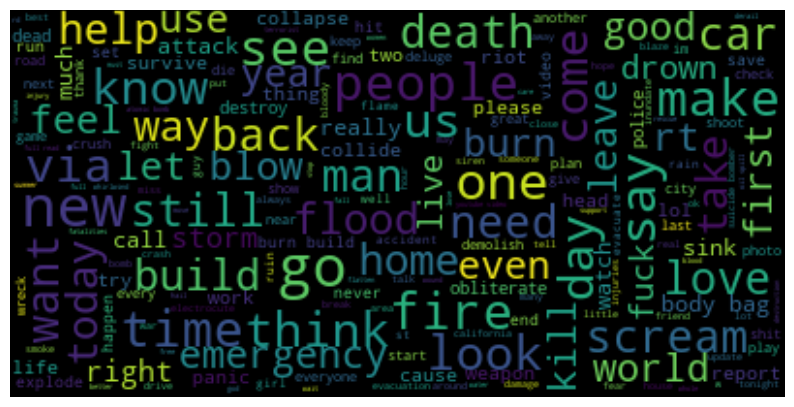

In [94]:
stopwords = set(STOPWORDS)
stopwords.update(['û','A','S','m','u'])
text = train_df['tweet_text']
#print(text[0:4])
# join the list and lowercase all the words
text = ' '.join(text).lower()
#print(text)
#create the wordcloud object
wordcloud = WordCloud(max_font_size=30,stopwords = stopwords,
                      collocations=True, ).generate(text)

#plot the wordcloud object
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [95]:
clean_news = train_df['tweet_text']

In [96]:
train_df['target']

0       1
1       0
2       1
3       0
4       0
       ..
5075    0
5076    0
5077    0
5078    0
5079    0
Name: target, Length: 5080, dtype: int64

In [97]:
corpus = []
for i in train_df['tweet_text']:
  corpus.append(i)

In [98]:
len(corpus)

5080

In [99]:
target = train_df['target']

In [ ]:
corpus

In [101]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(clean_news.values)
X = tokenizer.texts_to_sequences(clean_news.values)
X = pad_sequences(X)

In [131]:
#Model Building
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(704, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(352, activation='LeakyReLU'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 13, 120)           60000     
                                                                 
 spatial_dropout1d_11 (Spati  (None, 13, 120)          0         
 alDropout1D)                                                    
                                                                 
 lstm_11 (LSTM)              (None, 704)               2323200   
                                                                 
 dense_54 (Dense)            (None, 352)               248160    
                                                                 
 dense_55 (Dense)            (None, 256)               90368     
                                                                 
 dense_56 (Dense)            (None, 128)               32896     
                                                     

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.10, random_state=42, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape

((4572, 13), (508, 13), (4572,), (508,))

In [134]:
#Model Training
model.fit(X_train, y_train, epochs = 20, batch_size=32, verbose =1)

Epoch 1/20
143/143 [==============================] - 64s 444ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 2/20
143/143 [==============================] - 62s 434ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 3/20
143/143 [==============================] - 64s 447ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 4/20
143/143 [==============================] - 61s 429ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 5/20
143/143 [==============================] - 58s 406ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 6/20
143/143 [==============================] - 62s 431ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 7/20
143/143 [==============================] - 62s 431ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 8/20
143/143 [==============================] - 60s 421ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 9/20
143/143 [==============================] - 60s 422ms/step - loss: 0.0000e+00 - accuracy: 0.4348
Epoch 10/20
 32/143 [=====>..........

KeyboardInterrupt: 

In [ ]:
#Model Testing
model.evaluate(X_val,y_val)

In [ ]:
# from collections import Counter
# from itertools import chain

# # split words into lists
# v = train_df['tweet_text'].str.split().tolist() 
# # compute global word frequency
# c = Counter(chain.from_iterable(v))
# # filter, join, and re-assign
# tweets = [' '.join([j for j in i if c[j] > 1]) for i in v]

In [ ]:
# y = target
# X = np.array(tweets[:len(train_df)])
# X_test = np.array(tweets[len(test_df) :])
# X.shape, X_test.shape, y.shape

In [ ]:
# tf_idfvectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True)

In [37]:
# X_train = np.array(X_train).tolist()
# X_train = list(map(''.join, X_train))

# X_val = np.array(X_val).tolist()
# X_val = list(map(''.join, X_val))

# X_test = np.array(X_test).tolist()
# X_test = list(map(''.join, X_test))


# X_train_tfIdf = tf_idfvectorizer.fit_transform(X_train).toarray()
# X_val_tfIdf = tf_idfvectorizer.transform(X_val).toarray()
# X_test_tfIdf = tf_idfvectorizer.transform(X_test).toarray()
# print(tf_idfvectorizer.get_feature_names_out())

In [38]:
# X_train_tfIdf.shape, y_train.shape, X_val_tfIdf.shape,y_train.shape, X_test_tfIdf.shape

In [39]:
# X_train_tfIdf

In [40]:
# #model
# model = Sequential()
# model.add(Embedding(6000, 32, input_length=3951))
# model.add(LSTM(100))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# # Final evaluation of the model
# scores = model.evaluate(X_test_tfIdf[:508], X_val_tfIdf, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [41]:
# feature_len = X_train_tfIdf.shape[1]
# feature_len

In [42]:
# ## Creating model
# model = Sequential()
# model.add(Dense(500, input_shape=(feature_len,1), activation='relu'))
# model.add(Dropout(0.1))
# model.add(LSTM(256, input_shape = (feature_len,1)))
# model.add(Dropout(0.2))
# model.add(Dense(100, input_shape=(feature_len,), activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, input_shape=(feature_len,), activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
#  # Compile model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [43]:
# model.compile(loss='binary_crossentropy', 
#              optimizer='adam', 
#              metrics=['accuracy'])

In [44]:
# # batch_size = 32

# # model.fit(X_train_tfIdf, y_train, epochs = 500, batch_size=batch_size, verbose=1, shuffle=False)
# # validation_loss, validation_acc = model.evaluate(X_val_tfIdf, y_val)
# #Training
# model.fit(X_train_tfIdf,y_train,validation_data=(X_val_tfIdf,y_val),epochs=30,batch_size=64)


In [45]:
# onehot_repr = [one_hot(words,voc_size) for words in corpus]

In [46]:
# onehot_repr

In [47]:
# sent_length = 25
# embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
# print(embedded_docs)

In [48]:
# embedded_docs[0]

In [49]:
# len(embedded_docs),y.shape

In [50]:
# X_final=np.array(embedded_docs)
# y_final=np.array(y)

In [51]:
# X_final.shape,y_final.shape

In [52]:
# X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state = 42)

In [53]:
# #Training
# model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


In [54]:
# ## Creating model
# embedding_vector_features=40
# model1=Sequential()
# model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# model1.add(Dropout(0.1))
# model1.add(LSTM(128))

# model1.add(Dropout(0.2))

# # for units in [128,128,64,32]:

# # model.add(Dense(units,activation='relu'))

# # model.add(Dropout(0.2))

# model1.add(Dense(64,activation='relu'))

# model1.add(Dropout(0.2))
# model1.add(Dense(32,activation='relu'))
# model1.add(Dense(1,activation='sigmoid'))
# model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [55]:
# #Training
# model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)
